In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

# To suppress numeric values from being returned in exponential format
pd.options.display.float_format = '{:20,.2f}'.format

# To display all charts against a white background
plt.style.use('seaborn-whitegrid')

### Step 1. Loading Data

In [2]:
df_customer = pd.read_csv('./data/customer.csv')

In [3]:
df_customer.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20951 entries, 0 to 20950
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  20951 non-null  int64  
 1   first_name   20951 non-null  object 
 2   last_name    20951 non-null  object 
 3   city         20951 non-null  object 
 4   state_code   15238 non-null  object 
 5   zip          20951 non-null  int64  
 6   country      20951 non-null  object 
 7   latitude     20951 non-null  float64
 8   longitude    20951 non-null  float64
 9   opportunity  20951 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 1.6+ MB


In [4]:
df_customer.head()

,customer_id,first_name,last_name,city,state_code,zip,country,latitude,longitude,opportunity
0,50037,Franklinc,Spango,San Juan,PR,917,USA,39.56,-119.49,30000
1,50038,Derrel,Cazzell,San Juan,PR,918,USA,18.47,-66.11,105000
2,50039,Mayrely,Deitel,San Juan,PR,918,USA,39.56,-119.49,10000
3,50040,Beena,Karpay,San Juan,PR,918,USA,39.56,-119.49,105000
4,50041,Malachi,Winik,San Juan,PR,918,USA,18.47,-66.11,105000


In [5]:
df_customer.shape

(20951, 10)

In [6]:
df_customer.describe()

,customer_id,zip,latitude,longitude,opportunity
count,"20,951.00","20,951.00","20,951.00","20,951.00","20,951.00"
mean,"60,512.00","47,072.54",38.23,-90.02,"97,642.59"
std,"6,048.18","30,158.87",5.14,16.19,"176,565.13"
min,"50,037.00",917.00,18.42,-157.94,"10,000.00"
25%,"55,274.50","19,428.00",34.15,-96.79,"20,000.00"
50%,"60,512.00","45,202.00",39.83,-85.14,"42,000.00"
75%,"65,749.50","75,240.00",41.68,-77.18,"90,000.00"
max,"70,987.00","99,901.00",64.85,-66.06,"3,049,000.00"


In [7]:
df_txn = pd.read_csv('data/txn.csv')

In [8]:
df_txn.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   txn_id       1048575 non-null  int64  
 1   txn_date     1048575 non-null  object 
 2   customer_id  1048575 non-null  int64  
 3   symbol       1048575 non-null  object 
 4   sales        1048575 non-null  float64
 5   redemptions  1048575 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 48.0+ MB


In [9]:
df_txn.head()

,txn_id,txn_date,customer_id,symbol,sales,redemptions
0,422909780,5/2/2016,59532,AFNIX,"13,687.83",0.00
1,422909781,5/2/2016,60660,GABSX,0.00,"-4,286.23"
2,422909782,5/2/2016,52939,VTISX,"4,153.98",0.00
3,422909783,5/2/2016,52990,IMLAX,"27,452.30",0.00
4,422909784,5/2/2016,60343,MAPCX,"6,433.14",0.00


In [10]:
df_txn.shape

(1048575, 6)

In [11]:
df_txn.describe()

,txn_id,customer_id,sales,redemptions
count,"1,048,575.00","1,048,575.00","1,048,575.00","1,048,575.00"
mean,"423,434,067.00","60,509.66","5,476.56","-2,413.16"
std,"302,697.67","6,045.63","7,183.11","3,153.61"
min,"422,909,780.00","50,037.00",0.00,"-12,821.61"
25%,"423,171,923.50","55,274.00",0.00,"-4,439.99"
50%,"423,434,067.00","60,512.00",0.00,-138.19
75%,"423,696,210.50","65,744.00","10,088.88",0.00
max,"423,958,354.00","70,987.00","29,186.85",0.00


In [12]:
df_mutual_fund = pd.read_json('data/mutual_fund.json')

In [13]:
df_mutual_fund.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23783 entries, 0 to 23782
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   symbol     23783 non-null  object 
 1   name       23778 non-null  object 
 2   tna        23749 non-null  float64
 3   ms_rating  21976 non-null  float64
 4   size       22674 non-null  object 
 5   exp_ratio  23567 non-null  float64
dtypes: float64(3), object(3)
memory usage: 1.1+ MB


In [14]:
df_mutual_fund.head()

,symbol,name,tna,ms_rating,size,exp_ratio
0,AAAAX,DWS RREEF Real Assets Fund - Class A,"2,979,347,456.00",3.00,Large,0.01
1,AAAEX,Virtus AllianzGI Health Sciences Fund Class P,"195,348,944.00",3.00,Large,0.01
2,AAAFX,American Century One Choice Blend+ 2015 Portfo...,"25,946.00",NaN,Large,0.01
3,AAAGX,Thrivent Large Cap Growth Fund Class A,"2,078,606,848.00",4.00,Large,0.01
4,AAAHX,American Century One Choice Blend+ 2015 Portfo...,"25,946.00",NaN,Large,0.00


In [15]:
df_mutual_fund.shape

(23783, 6)

In [16]:
df_mutual_fund.describe()

,tna,ms_rating,exp_ratio
count,"23,749.00","21,976.00","23,567.00"
mean,"4,924,192,363.80",3.10,0.01
std,"21,097,647,864.75",1.08,0.01
min,10.00,1.00,0.00
25%,"144,583,360.00",2.00,0.01
50%,"644,328,320.00",3.00,0.01
75%,"2,453,408,768.00",4.00,0.01
max,"753,409,982,464.00",5.00,0.12


### Step 2. Exploratory Data Analysis (EDA)

##### 2.1. Sales and redemptions by customer


In [17]:
# Sales and redemptions by Customer - restricted to Top 10 by Sales
df_sales_by_cust = df_txn.groupby(['customer_id']).sum()[['sales', 'redemptions']].sort_values(by='sales', ascending=False).head(10)
print(df_sales_by_cust.head())
print()
print(df_sales_by_cust.shape[0])

                           sales          redemptions
customer_id                                          
66141                 576,984.37          -120,904.71
70941                 549,850.76          -147,380.24
58060                 540,494.96           -62,220.53
56531                 531,871.82           -59,766.72
52754                 527,923.92          -148,068.06

10


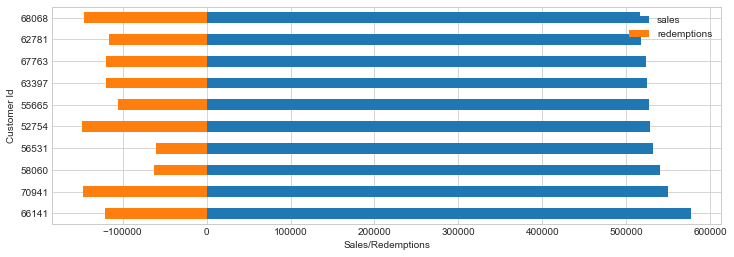

In [18]:
df_sales_by_cust.plot(kind='barh', stacked=True, figsize=(12, 4)).legend(loc='upper right')
plt.title='Sales and Redemptions by Customer'
plt.xlabel('Sales/Redemptions')
plt.ylabel('Customer Id');

##### 2.2. Sales and redemptions by mutual fund

In [19]:
# Sales and Redemptions by Top 10 Mutual Funds
df_sales_by_fund = df_txn.groupby(['symbol']).sum()[['sales', 'redemptions']].sort_values(by='sales', ascending=False).head(10)
print(df_sales_by_fund.head())
print()
print(df_sales_by_fund.shape[0])

                      sales          redemptions
symbol                                          
MSDCX            856,314.66          -207,858.66
LCRRX            826,716.30          -211,586.65
FFQZX            825,552.52          -248,619.59
BSPIX            801,182.43          -210,506.32
CMACX            797,674.56          -272,037.97

10


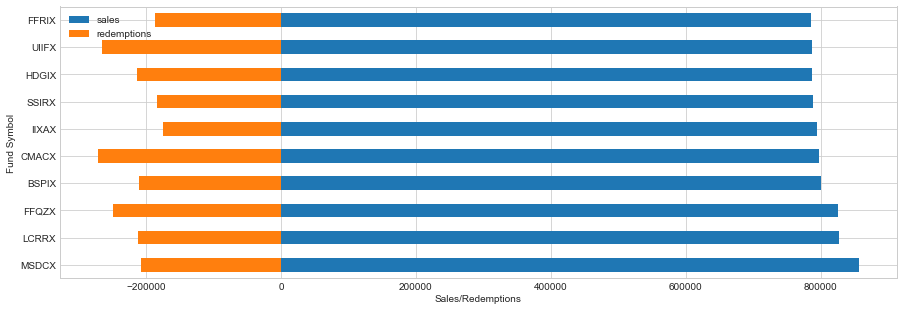

In [20]:
df_sales_by_fund.plot(kind='barh', stacked=True, figsize=(15, 5)).legend(loc='upper left')
plt.title='Sales and Redemptions by Customer'
plt.xlabel('Sales/Redemptions')
plt.ylabel('Fund Symbol');


##### 2.3. Sales and redemptions by customer and mutual fund

In [21]:
df_sales_by_cust_fund = df_txn.groupby(['customer_id', 'symbol']).sum()[['sales', 'redemptions']].sort_values(by=['customer_id', 'symbol', 'sales'], ascending=False)
print(df_sales_by_cust_fund.head(10))
print()
print(df_sales_by_cust_fund.shape[0])

                                  sales          redemptions
customer_id symbol                                          
70987       VYSDX                  0.00            -4,381.39
            TRSAX                  0.00            -5,021.45
            TISIX                  0.00            -3,372.34
            SUNBX              6,205.39                 0.00
            STDFX                  0.00            -8,109.27
            SFECX                  0.00            -5,417.76
            SEMCX                  0.00            -3,087.45
            SCSPX                  0.00            -4,940.69
            ROBNX                  0.00            -3,378.37
            RNDLX                  0.00            -1,544.94

1046390


##### 2.4. A deeper look at fund attribute-based aggregations

In [22]:
# Sales and redemptions by MS Rating
df_sales_by_ms_rating = pd.merge(left=df_txn, right=df_mutual_fund, on='symbol')[['ms_rating', 'sales', 'redemptions']].groupby(['ms_rating']).sum([['sales', 'redemptions']])
df_sales_by_ms_rating.head()

,sales,redemptions
ms_rating,,
1.00,"390,448,899.42","-170,238,228.73"
2.00,"1,120,082,048.39","-491,015,532.96"
3.00,"1,966,911,888.18","-866,222,003.72"
4.00,"1,301,368,936.06","-577,776,674.22"
5.00,"567,949,882.52","-249,320,470.32"


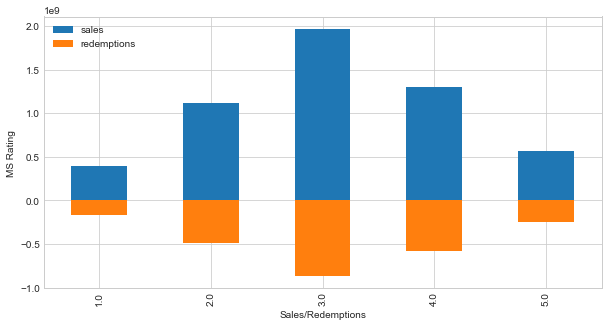

In [23]:
df_sales_by_ms_rating.plot(kind='bar', stacked=True, figsize=(10, 5)).legend(loc='upper left')
plt.title='Sales and Redemptions by Morning Star Rating'
plt.xlabel('Sales/Redemptions')
plt.ylabel('MS Rating');

In [24]:
# Sales and redemptions by Size
df_sales_by_size = pd.merge(left=df_txn, right=df_mutual_fund, on='symbol')[['size', 'sales', 'redemptions']].groupby(['size']).sum([['sales', 'redemptions']])
df_sales_by_size.head()

,sales,redemptions
size,,
Large,"3,202,668,833.37","-1,403,907,288.82"
Medium,"1,335,869,935.18","-591,358,063.86"
Small,"950,395,378.67","-422,789,418.60"


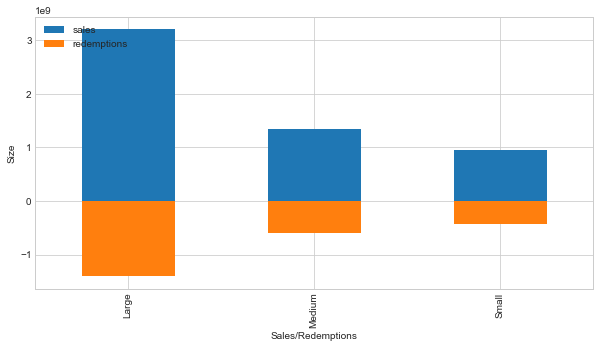

In [25]:
df_sales_by_size.plot(kind='bar', stacked=True, figsize=(10, 5)).legend(loc='upper left')
plt.title='Sales and Redemptions by Size'
plt.xlabel('Sales/Redemptions')
plt.ylabel('Size');

##### 2.5. A deeper look at customer attribute-based aggregations

In [26]:
# Sales and redemptions by Customer
df_sales_by_cust_opp = pd.merge(left=df_txn, right=df_customer, on='customer_id')[['customer_id', 'opportunity', 'sales', 'redemptions']].groupby(['customer_id', 'opportunity']).sum([['sales', 'redemptions']])
df_sales_by_cust_opp.head()

,,sales,redemptions
customer_id,opportunity,,
50037,30000,"306,751.44","-155,164.77"
50038,105000,"361,158.77","-96,853.36"
50039,10000,"426,594.74","-139,711.70"
50040,105000,"244,707.71","-74,396.43"
50041,105000,"293,969.41","-106,756.21"


In [27]:
# Sales and redemptions by geographic location
df_sales_by_state = pd.merge(left=df_txn, right=df_customer, on='customer_id')[['state_code', 'sales', 'redemptions']].groupby(['state_code']).sum([['sales', 'redemptions']]).sort_values(by='sales', ascending=False)
df_sales_by_state.head()

,sales,redemptions
state_code,,
NY,"567,524,392.44","-246,541,075.36"
FL,"375,786,466.08","-168,560,917.47"
PA,"276,170,949.21","-123,118,853.75"
IL,"265,259,071.56","-116,787,205.17"
NJ,"246,652,189.70","-106,748,488.73"


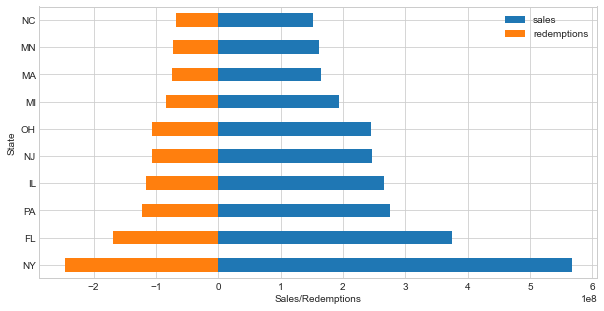

In [28]:
df_sales_by_state.head(10).plot(kind='barh', stacked=True, figsize=(10, 5)).legend(loc='upper right')
plt.title='Sales and Redemptions by State'
plt.xlabel('Sales/Redemptions')
plt.ylabel('State');

### Step 3. Feature Engineering

In this section, I would like to identify the various features that we can pull out of this data to help us build recommendations. I will classify these features based on the dataset below:

###### Mutual Funds
1. **Morningstar Rating**: This is ranking given to publicly traded mutual funds and exchange traded funds by the investment research firm Morningstar. Risk is assessed at five levels designed to help investors quickly identify funds to consider for their portfolios. More information can be found at https://www.investopedia.com/terms/m/morningstarriskrating.asp. In general, funds with a rating of 4 and 5 are highly sought after. They may be considered as Strong Buys. Funds with a rating of 1 or 2 may be considered Strong Sells while those with a rating of 3 may be considered as
2. **Size**: Broadly classified into three categories (Small, Medium and Large), this indicates the sizes of the companies in which the Mutual Fund invests.
3. **Expense Ratio**: This is a continuous numeric value and is not much useful to us as it is. However, we can broadly classify these into three categories - Low: less than 0.5%, Reasonable: between 0.5% and 1% and High: above 1%.

##### Customers
4. **Opportunity**: This is also a continuous numeric value and indicates the amount upto which a customer may be willing to invest. This is assessed daily and set to the maximum value of sales for a given customer over the entire history of the customer's relationship with the investment company. While the amount is not very useful in itself for our purpose, we can engineer it as a metric to indicate whether a sale is possible. To make that assessment, we could say that a sale is possible if the total sales of a given customer is less than 75% of the opportunity marked against that customer. When recommending funds to a customer, we can take this metric into account as well.

#### Transactions
5. **Net Sales**: This is the total sales of a given customer of a given product after deducting redemptions from the same. We could impute that a positive number (preferably subject to a minimum threshold) indicates that the customer recommends that product. Otherwise, not.

In the following cells, I will turn these features into 1 and 0 value matrices that we can later use to build out our recommendations.

##### 3.1 Add necessary columns to the datasets as per discussion above containing 0 and 1 values

In [29]:
# Extracting features for Mutual Funds
# Using MS Ratings higher than 3 to set a new column named 'buy' to 1 and 0 otherwise
# First, let us sat NaN values to 0 to indicate that they are not rated
df_mutual_fund['ms_rating'].fillna(value=0, inplace=True)

# Add a new column to the Mutual Funds dataset named 'buy' and set it to 0 or 1 values
df_mutual_fund['buy'] = (df_mutual_fund['ms_rating'] > 3).astype(int)
df_mutual_fund.head()

,symbol,name,tna,ms_rating,size,exp_ratio,buy
0,AAAAX,DWS RREEF Real Assets Fund - Class A,"2,979,347,456.00",3.00,Large,0.01,0
1,AAAEX,Virtus AllianzGI Health Sciences Fund Class P,"195,348,944.00",3.00,Large,0.01,0
2,AAAFX,American Century One Choice Blend+ 2015 Portfo...,"25,946.00",0.00,Large,0.01,0
3,AAAGX,Thrivent Large Cap Growth Fund Class A,"2,078,606,848.00",4.00,Large,0.01,1
4,AAAHX,American Century One Choice Blend+ 2015 Portfo...,"25,946.00",0.00,Large,0.00,0


In [30]:
# Using the values in Size column to set new columns named Small, Medium and Large to 0 and 1 values
df_mutual_fund['small'] = (df_mutual_fund['size'] == 'Small').astype(int)
df_mutual_fund['medium'] = (df_mutual_fund['size'] == 'Medium').astype(int)
df_mutual_fund['large'] = (df_mutual_fund['size'] == 'Large').astype(int)
df_mutual_fund.head()

,symbol,name,tna,ms_rating,size,exp_ratio,buy,small,medium,large
0,AAAAX,DWS RREEF Real Assets Fund - Class A,"2,979,347,456.00",3.00,Large,0.01,0,0,0,1
1,AAAEX,Virtus AllianzGI Health Sciences Fund Class P,"195,348,944.00",3.00,Large,0.01,0,0,0,1
2,AAAFX,American Century One Choice Blend+ 2015 Portfo...,"25,946.00",0.00,Large,0.01,0,0,0,1
3,AAAGX,Thrivent Large Cap Growth Fund Class A,"2,078,606,848.00",4.00,Large,0.01,1,0,0,1
4,AAAHX,American Century One Choice Blend+ 2015 Portfo...,"25,946.00",0.00,Large,0.00,0,0,0,1


In [31]:
# Using Expense Ratio values to add new columns named "er_low', 'er_medium' and 'er_high'
# First let us set all NaN values to zero which is a reasonable replacement; if an expense ration is not available, we can consider it to be 0
df_mutual_fund['exp_ratio'].fillna(value=0, inplace=True)

# Add the new columns
df_mutual_fund['er_low'] = (df_mutual_fund['exp_ratio'] * 100 < 0.5).astype(int)
df_mutual_fund['er_medium'] = (np.logical_and(df_mutual_fund['exp_ratio'] * 100 >= 0.5, df_mutual_fund['exp_ratio'] * 100 <= 1.0)).astype(int)
df_mutual_fund['er_high'] = (df_mutual_fund['exp_ratio'] * 100 > 1.0).astype(int)

In [32]:
# Extracting features for Customer
# Use the 'opportunity' data and set a new column with 1 if the total sales of a customer is less than 75% of the opportunity value for that customer
# Otherwise, set it to 0

df_cust_tmp = pd.merge(df_txn.groupby('customer_id').sum()['sales'].reset_index(), df_customer, on='customer_id')[['customer_id', 'sales', 'opportunity']]
df_customer['sale_opportunity'] = (df_cust_tmp['sales'] * .75 < df_cust_tmp['opportunity']).astype(int)

In [33]:
# Extracting features for Transactions
# Use the net sales value (Sales - Redemptions) grouped by fund to set a new column titled 'fund_recommended' to 1 if net sales > 250,000; 0 otherwise
df_txn_tmp = (df_txn.groupby('symbol').sum()['sales'] + df_txn.groupby('symbol').sum()['redemptions']).to_frame().reset_index()
df_txn_tmp.columns = ['symbol', 'net_sales']
df_txn['fund_recommended'] = (df_txn_tmp['net_sales'] > 250000).astype(int)
df_txn.head(10)

,txn_id,txn_date,customer_id,symbol,sales,redemptions,fund_recommended
0,422909780,5/2/2016,59532,AFNIX,"13,687.83",0.00,1.00
1,422909781,5/2/2016,60660,GABSX,0.00,"-4,286.23",1.00
2,422909782,5/2/2016,52939,VTISX,"4,153.98",0.00,1.00
3,422909783,5/2/2016,52990,IMLAX,"27,452.30",0.00,1.00
4,422909784,5/2/2016,60343,MAPCX,"6,433.14",0.00,1.00
5,422909785,5/2/2016,66341,JACAX,"1,124.98",0.00,1.00
6,422909786,5/2/2016,65708,MEAIX,0.00,"-6,891.62",0.00
7,422909787,5/2/2016,52204,FPACX,0.00,"-4,252.69",0.00
8,422909788,5/2/2016,54242,EGRCX,"11,588.50",0.00,0.00
9,422909789,5/2/2016,57716,AGGCX,"9,011.30",0.00,0.00


In [34]:
# Create a Customer-Mutual Fund interaction dataset from df_txn
df_cust_fund_interactions = df_txn[['customer_id', 'symbol', 'fund_recommended']].drop_duplicates()

In [35]:
df_cust_fund_interactions.head()

,customer_id,symbol,fund_recommended
0,59532,AFNIX,1.00
1,60660,GABSX,1.00
2,52939,VTISX,1.00
3,52990,IMLAX,1.00
4,60343,MAPCX,1.00


##### 3.3 Create the necessary matrices with the above data

In [36]:
def create_feature_matrix(df, index, column, value, fill_na_val=0):
    """
    A function that accepts a source dataframe and creates a 1/0 value feature matrix out of it based on inputs
    It fills NaN values with the fill_na_val parameter passed in
    :param df: (pandas.core.frame.DataFrame) source dataframe that contains the data
    :param index: (str) the column that should be used as row header in the matrix
    :param column: (str) the column that should be pivoted as multiple columns
    :param value: (str) the column that contains the values for the pivoted columns
    :param fill_na_val: (int) defaults to 0
    :return: (pandas.core.frame.DataFrame) the dataframe containing the matrix
    """

    try:
        matrix = df.pivot(index=index, columns=column, values=value).fillna(value=fill_na_val)
    except ValueError:
        # In case the pivot method throws an exception, try the pivot_table method
        matrix = df.pivot_table(index=index, columns=column, values=value, aggfunc='sum').fillna(value=fill_na_val)

    return matrix

###### 3.3.1 Create a matrix to hold Customer-Fund Buy values

In [37]:
input_df = pd.merge(df_cust_fund_interactions, df_mutual_fund, on='symbol')[['customer_id', 'symbol', 'buy']].drop_duplicates()
df_cust_fund_buy_matrix = create_feature_matrix(input_df, 'customer_id', 'symbol', 'buy')

In [38]:
df_cust_fund_buy_matrix.head()

symbol,AAAAX,AAAHX,AAAIX,AAAJX,AAAKX,AAAMX,AAASX,AAATX,AABAX,AABEX,...,YASSX,YFSIX,YOVLX,ZDIVX,ZEOIX,ZFLIX,ZSCCX,ZSCIX,ZVGIX,ZVNIX
customer_id,,,,,,,,,,,,,,,,,,,,,
50037,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50038,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50039,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50040,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50041,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


###### 3.3.2 Crate matrices to hold Customer-Fund Size values - one each for small, medium and large

In [39]:
df_cust_fund_size = pd.merge(df_cust_fund_interactions, df_mutual_fund, on='symbol')[['customer_id', 'symbol', 'small', 'medium', 'large']].drop_duplicates()

In [40]:
df_cust_fund_size.head()

,customer_id,symbol,small,medium,large
0,59532,AFNIX,0,0,1
1,54056,AFNIX,0,0,1
2,56891,AFNIX,0,0,1
3,50911,AFNIX,0,0,1
4,63929,AFNIX,0,0,1


In [44]:
df_cust_fund_small_matrix = create_feature_matrix(df_cust_fund_size, 'customer_id', 'symbol', 'small')
df_cust_fund_medium_matrix = create_feature_matrix(df_cust_fund_size, 'customer_id', 'symbol', 'medium')
df_cust_fund_large_matrix = create_feature_matrix(df_cust_fund_size, 'customer_id', 'symbol', 'large')

In [45]:
print(df_cust_fund_small_matrix.head())
print(df_cust_fund_medium_matrix.head())
print(df_cust_fund_large_matrix.head())

symbol                     AAAAX                AAAHX                AAAIX  \
customer_id                                                                  
50037                       0.00                 0.00                 0.00   
50038                       0.00                 0.00                 0.00   
50039                       0.00                 0.00                 0.00   
50040                       0.00                 0.00                 0.00   
50041                       0.00                 0.00                 0.00   

symbol                     AAAJX                AAAKX                AAAMX  \
customer_id                                                                  
50037                       0.00                 0.00                 0.00   
50038                       0.00                 0.00                 0.00   
50039                       0.00                 0.00                 0.00   
50040                       0.00                 0.00          

###### 3.3.3 Crate a matrix to hold Customer-Fund Expense Ratio values - one each for low, medium and high

In [47]:
df_cust_fund_er = pd.merge(df_cust_fund_interactions, df_mutual_fund, on='symbol')[['customer_id', 'symbol', 'er_low', 'er_medium', 'er_high']].drop_duplicates()

In [48]:
df_cust_fund_er.head()

,customer_id,symbol,er_low,er_medium,er_high
0,59532,AFNIX,0,1,0
1,54056,AFNIX,0,1,0
2,56891,AFNIX,0,1,0
3,50911,AFNIX,0,1,0
4,63929,AFNIX,0,1,0


In [49]:
df_cust_fund_er_low_matrix = create_feature_matrix(df_cust_fund_er, 'customer_id', 'symbol', 'er_low')
df_cust_fund_er_medium_matrix = create_feature_matrix(df_cust_fund_er, 'customer_id', 'symbol', 'er_medium')
df_cust_fund_er_high_matrix = create_feature_matrix(df_cust_fund_er, 'customer_id', 'symbol', 'er_high')

In [50]:
print(df_cust_fund_er_low_matrix.head())
print(df_cust_fund_er_medium_matrix.head())
print(df_cust_fund_er_high_matrix.head())

symbol                     AAAAX                AAAHX                AAAIX  \
customer_id                                                                  
50037                       0.00                 0.00                 0.00   
50038                       0.00                 0.00                 0.00   
50039                       0.00                 0.00                 0.00   
50040                       0.00                 0.00                 0.00   
50041                       0.00                 0.00                 0.00   

symbol                     AAAJX                AAAKX                AAAMX  \
customer_id                                                                  
50037                       0.00                 0.00                 0.00   
50038                       0.00                 0.00                 0.00   
50039                       0.00                 0.00                 0.00   
50040                       0.00                 0.00          

###### 3.3.4 Crate a matrix to hold Customer-Fund Sale Opportunity

In [52]:
input_df = pd.merge(df_cust_fund_interactions, df_customer, on='customer_id')[['customer_id', 'symbol', 'sale_opportunity']].drop_duplicates()
df_cust_fund_sale_matrix = create_feature_matrix(input_df, 'customer_id', 'symbol', 'sale_opportunity')

In [53]:
df_cust_fund_sale_matrix.head()

symbol,AAAAX,AAAHX,AAAIX,AAAJX,AAAKX,AAAMX,AAASX,AAATX,AABAX,AABEX,...,YASSX,YFSIX,YOVLX,ZDIVX,ZEOIX,ZFLIX,ZSCCX,ZSCIX,ZVGIX,ZVNIX
customer_id,,,,,,,,,,,,,,,,,,,,,
50037,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50038,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50039,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50040,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50041,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


###### 3.3.5 Crate a matrix to hold Customer-Fund Recommendation based on high net sales

In [55]:
# input_df = df_cust_fund_interactions.pivot_table(index='customer_id', columns='symbol', values='fund_recommended', aggfunc='sum').fillna(value=0)
df_cust_fund_rec_matrix = create_feature_matrix(df_cust_fund_interactions, 'customer_id', 'symbol', 'fund_recommended')

In [56]:
print(type(df_cust_fund_rec_matrix))
df_cust_fund_rec_matrix.head()

<class 'pandas.core.frame.DataFrame'>


symbol,AAAAX,AAAHX,AAAIX,AAAJX,AAAKX,AAAMX,AAASX,AAATX,AABAX,AABEX,...,YASSX,YFSIX,YOVLX,ZDIVX,ZEOIX,ZFLIX,ZSCCX,ZSCIX,ZVGIX,ZVNIX
customer_id,,,,,,,,,,,,,,,,,,,,,
50037,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50038,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50039,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50040,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50041,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
